In [1]:
from tensorflow.keras.layers import Dense, Input

In [2]:
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
np.random.seed(1337)

In [4]:
#load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()


In [5]:
# reshape to (28,28,1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1,image_size,image_size,1])
x_test =np.reshape(x_test,[-1,image_size,image_size,1])
x_train = x_train.astype('float')/255
x_test = x_test.astype('float')/255

In [9]:
#generate corrupted MNIST images by adding nise with normal dist cetered at 0.5 and std = 0.5
noise = np.random.normal(loc = 0.5, scale = 0.5, size=x_train.shape)
x_train_noisy = x_train + noise


In [12]:
noise = np.random.normal(loc = 0.5, scale = 0.5, size=x_test.shape)
x_test_noisy = x_test + noise
# adding noise may exceeed normalized pixel values > 1.0 or <0.0
# clip pixel values > 1.0 to 1.0 and  <0.0 to 0.0
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
#network parameters
input_shape = (image_size, image_size, 1)
batch_size = 32
kernel_size = 3
latent_dim = 16
# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32,64]

In [13]:
#build encoder model
inputs = Input(shape= input_shape, name='encoder_input')
x= inputs

In [14]:
#stack of Conv2D (32)-Conv2D(64)
for filters in layer_filters:
  x = Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)

In [15]:
# shape infor needed to build decoder model so we do not do hand computation
# The input to the decoder's first Conv2DTranspose will have this shape
# Shape is (7,7,64) which can be pricessed by the decoder back to (28,28,1)
shape = K.int_shape(x)

In [16]:
#generate the latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)
#instantetiate encoder model
encoder = Model(inputs, latent, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                50192     
Total params: 69,008
Trainable params: 69,008
Non-trainable params: 0
_________________________________________________________________


In [17]:
#build the decoder model
latent_inputs = Input(shape=(latent_dim,), name= 'decoder_input')
# use the shape (7,7,64) that was saved earlier
x=Dense(shape[1]*shape[2]*shape[3])(latent_inputs)
# from vector to suitable shpa for transposed conv
x = Reshape((shape[1], shape[2], shape[3]))(x)

In [18]:
#stack of Conv2DTranspose(64)-Conv2DTranspose(32)
for filters in layer_filters[::-1]:
  x =  Conv2DTranspose(
      filters=filters,
      kernel_size=kernel_size,
      strides=2,
      activation='relu',
      padding='same'
  )(x)

In [19]:
# Reconstruct the denoised input
outputs = Conv2DTranspose(
    filters=1,
    kernel_size=kernel_size,
    padding='same',
    activation='sigmoid',
    name='decoder_output'
)(x)

In [20]:
# instantitate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 3136)              53312     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 28, 28, 1)         289       
Total params: 108,993
Trainable params: 108,993
Non-trainable params: 0
_____________________________________________________

In [21]:
# autoencoder = encoder + decoder
#instantiate autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 16)                69008     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         108993    
Total params: 178,001
Trainable params: 178,001
Non-trainable params: 0
_________________________________________________________________


In [22]:
#Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss = 'mse',optimizer='adam')
#train auto encoder model
autoencoder.fit(x_train_noisy,x_train,validation_data=(x_test_noisy,x_test), epochs=10, batch_size=batch_size)

Epoch 1/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0549 - val_loss: 0.0199
Epoch 2/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0194 - val_loss: 0.0178
Epoch 3/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0176 - val_loss: 0.0169
Epoch 4/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 5/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0163 - val_loss: 0.0163
Epoch 6/10
1875/1875 [==============================] - 85s 46ms/step - loss: 0.0158 - val_loss: 0.0163
Epoch 7/10
1875/1875 [==============================] - 85s 46ms/step - loss: 0.0155 - val_loss: 0.0160
Epoch 8/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0153 - val_loss: 0.0158
Epoch 9/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.0152 - val_loss: 0.0158
Epoch 10/10
1875/1875 [==============================] - 86s 46m

In [23]:
#predict the autoencoder output from currupted test images
x_decoded = autoencoder.predict(x_test_noisy)

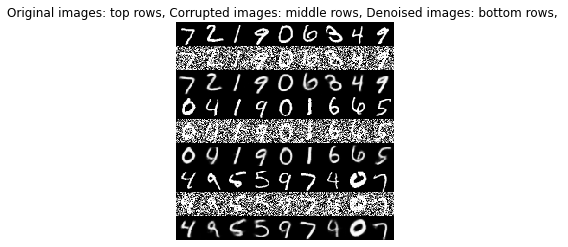

In [24]:
# 3 sets of images with 9 MNIST digits
#1st rows - original images
# 2nd rows- images corrupted by noise
# 3rd rows- denoised images

rows, cols=3,9
num = rows * cols
imgs = np.concatenate([x_test[:num], x_test_noisy[:num],x_decoded[:num]])
imgs = imgs.reshape((rows*3, cols, image_size, image_size))
imgs = np.vstack(np.split(imgs, rows, axis=1))
imgs = imgs.reshape((rows*3,-1, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
imgs = (imgs *255).astype(np.uint8)
plt.figure()
plt.axis('off')
plt.title('Original images: top rows, '
'Corrupted images: middle rows, ' 
'Denoised images: bottom rows, '
)
plt.imshow(imgs, interpolation='none', cmap='gray')
Image.fromarray(imgs).save('Corrupted_and_denoised.png')
plt.show()

The noise added is a Gaussian distribution with a mean of 0.5 and standard deviation of 0.5